# Optimal training of a variational quantum algorithm without barren plateaus

"Optimal training of variational quantum algorithms without barren plateaus" by T. Haug,, M.S. Kim

Example code to optimally learn quantum states with a variational quantum algorithm. Uses the quantum Fisher information metric to calculate optimal adaptive learning rate for gradient ascent. Further uses quantum natural gradient or generalized quantum natural gradient for optimal movement in parameter space. 
Quantum natural gradient (beta=1) requires regularization (adding epsilon*identity to quantum Fisher information metric) in order to run stable. 
Generalized quantum natural gradient (beta=0.5) is stable by default runs without need any regularization.

Based on qutip.

@author: Tobias Haug, github txhaug
Imperial College London

Contact at thaug@ic.ac.uk


In [1]:
import qutip as qt

from functools import partial

import operator
from functools import reduce
import numpy as np

import scipy
import matplotlib.pyplot as plt

In [2]:
def prod(factors):
    return reduce(operator.mul, factors, 1)


def flatten(l):
    return [item for sublist in l for item in sublist]

#tensors operators together 
def genFockOp(op,position,size,levels=2,opdim=0):
    opList=[qt.qeye(levels) for x in range(size-opdim)]
    opList[position]=op
    return qt.tensor(opList)

#construct from parameter 1D list a 2D array with [depth,n_qubits], ignore unused rotations where paulis2d=0
def construct_2d_parameters(angles,paulis2d,extraangles=0):
    depth,n_qubits=np.shape(paulis2d)
    angles2d=np.zeros([depth,n_qubits])
    counter=0
    for i in range(depth):
        for j in range(n_qubits):
            if(paulis2d[i,j]!=0):
                angles2d[i,j]=angles[counter]
                counter+=1
    if(extraangles==0):
        return angles2d
    else:
        return angles2d,angles[counter:]

#take parameters as a 2D array with [depth,n_qubits] to do 1D list, ignore unused rotations where paulis2d=0
def construct_1d_parameters(angles2d,paulis2d):
    depth,n_qubits=np.shape(paulis2d)
    angles1d=[]
    for i in range(depth):
        for j in range(n_qubits):
            if(paulis2d[i,j]!=0):
                angles1d.append(angles2d[i,j])
    
    return np.array(angles1d)




Set parameters here for circuit

In [20]:
seed=1 #seed of random generator


n_qubits=6 #number qubits
depth=6 #number of layers with rotations, i.e. in each layer are n_qubit rotations.

type_circuit=0 ##0: Y-Z rotations with CNOT gates every 2 layers 1: Y-Z rotations with \sqrt(iSWAP) every 2 layers

initial_angles=0 ##0: random angles

target_state_initial_infidelity=0.7 #initial infidelity of target state to be learned. Between 0 and 1 allowed

n_training=10 #number training steps

qfi_regularization=10**-1 ##regularization of QFIM needed for quantum natural gradient for Quantum natural gradient (beta=1)



In [21]:
if(n_qubits%2==1):
    raise NameError("Only even number of qubits allowed")

cutoff_eigvals=10**-12 #cutoff for eigenvalues for inversion of QFIM

#random generator used
rng = np.random.default_rng(seed)

#define angles for circuit
ini_angles=np.zeros([depth,n_qubits])
if(initial_angles==0):
    ini_angles=rng.random([depth,n_qubits])*2*np.pi


#define rotations for circuit in each layer, 0: identity, 1: X, 2:Y 3:Z
ini_pauli=np.zeros([depth,n_qubits],dtype=int)

if(type_circuit==0 or type_circuit==1):
    #set odd and even layers
    ini_pauli[0:depth:2,:]=2 #y rotation
    ini_pauli[1:depth:2,:]=3 #z rotation

        
        

#set type of entangling operations
if(type_circuit==0):#CNOT gate
    U_entangling=qt.qip.operations.cnot()
if(type_circuit==1):#CNOT gate
    U_entangling=qt.qip.operations.sqrtiswap()
    

#set which qubits entangler is acting on
entangling_gate_index_list=[]
if(type_circuit==0 or type_circuit==1):#alternating arrangement
    for i in range(depth):
        if(i%2==0 or i==depth-1):#leave 0,2,4,... layers empty of entangler, as well as last one
            entangling_gate_index_list.append([])
        else:
            #alternating application of entangling gates
            if(i%4==1):
                entangling_gate_index_list.append([[2*i,2*i+1] for i in range(n_qubits//2)])
            if(i%4==3):
                entangling_gate_index_list.append([[2*i+1,(2*i+2)%n_qubits] for i in range(n_qubits//2)])

#operators for circuit
levels=2#
opZ=[genFockOp(qt.sigmaz(),i,n_qubits,levels) for i in range(n_qubits)]
opX=[genFockOp(qt.sigmax(),i,n_qubits,levels) for i in range(n_qubits)]
opY=[genFockOp(qt.sigmay(),i,n_qubits,levels) for i in range(n_qubits)]
opId=genFockOp(qt.qeye(levels),0,n_qubits)
opZero=opId*0
zero_state=qt.tensor([qt.basis(levels,0) for i in range(n_qubits)])
      
#construct unitaries for entangling layer
all_entangling_layers=[]         
for ind in range(len(entangling_gate_index_list)):
    entangling_gate_index=entangling_gate_index_list[ind]
    if(len(entangling_gate_index)==0):
        entangling_layer=opId
    else:
        entangling_layer=prod([qt.qip.operations.gate_expand_2toN(U_entangling,n_qubits,j,k) for j,k in entangling_gate_index[::-1]])

    all_entangling_layers.append(entangling_layer)

#calculate number of parameters
n_parameters=len(construct_1d_parameters(ini_angles,ini_pauli))

##check which paulis at what depth and qubit is identitity or not
parameter_where=np.zeros([n_parameters,2],dtype=int)
counter=0
for i in range(depth):
    for j in range(n_qubits):
        if(ini_pauli[i,j]!=0):
            parameter_where[counter]=[i,j]
            counter+=1


##H=opZ[0]*opZ[1] #local Hamiltonian to calculate energy and gradient from



In [22]:
#calculates loss and gradients
def calculate_loss_gradients(input_angles,input_paulis,get_gradients=True):
    
    initial_state_save=qt.tensor([qt.basis(levels,0) for i in range(n_qubits)])

    #save here quantum state of gradient for qfi
    grad_state_list=[]
    #list of values of gradient
    gradient_list=np.zeros(n_parameters)
    
    save_rot_op=[]
    #save single-qubit rotations here so we can reuse them
    for j in range(depth):
        rot_op=[]
        for k in range(n_qubits):
            angle=input_angles[j][k]
            type_pauli=input_paulis[j][k]
            if(type_pauli==1):
                rot_op.append(qt.qip.operations.rx(angle))
            elif(type_pauli==2):
                rot_op.append(qt.qip.operations.ry(angle))
            elif(type_pauli==3):
                rot_op.append(qt.qip.operations.rz(angle))
            elif(type_pauli==0):
                rot_op.append(qt.qeye(2))
                
        save_rot_op.append(qt.tensor(rot_op))
        

    #p goes from -1 to n_parameters-1. -1 is to calculate quantum state, rest for gradient
    if(get_gradients==True):
        #calculate gradients by doing n_parameters+1 calcuations
        n_p=n_parameters
    else:
        #without gradient, need only one calculation
        n_p=0
        
    for p in range(-1,n_p):
        initial_state=qt.Qobj(initial_state_save)

        for j in range(depth):
            apply_rot_op=save_rot_op[j]
            
            #for p>=0, we are calculating gradients. Here, we need to add derivative of repsective parameter
            if(p!=-1 and j==parameter_where[p][0]):
                which_qubit=parameter_where[p][1]
                type_pauli=input_paulis[j][which_qubit]
                if(type_pauli==1):
                    apply_rot_op=apply_rot_op*(-1j*opX[which_qubit]/2)
                elif(type_pauli==2):
                    apply_rot_op=apply_rot_op*(-1j*opY[which_qubit]/2)
                elif(type_pauli==3):
                    apply_rot_op=apply_rot_op*(-1j*opZ[which_qubit]/2)

            #apply single qubit rotations
            initial_state=apply_rot_op*initial_state


            #apply entangling layer
            initial_state=all_entangling_layers[j]*initial_state

        if(p==-1):
            #calculate loss
            circuit_state=qt.Qobj(initial_state)#state generated by circuit
            if(loss_hamiltonian==True):
                #loss is hamiltonian
                loss=qt.expect(H,circuit_state)
            else:
                #loss is infidelity with target state H_state
                loss=1-np.abs(circuit_state.overlap(H_state))**2

    
        else:
            #calculate gradient
            grad_state_list.append(qt.Qobj(initial_state))#state with gradient applied for p-th parameter

            if(loss_hamiltonian==True):
                gradient_list[p]=2*np.real(circuit_state.overlap(H*initial_state))
            else:
                gradient_list[p]=2*np.real(circuit_state.overlap(initial_state)-circuit_state.overlap(H_state)*H_state.overlap(initial_state))


    return circuit_state,grad_state_list,loss,gradient_list

In [23]:
#calculates quantum Fisher information metric
def calculate_qfim(circuit_state,grad_state_list):
    n_parameters=len(grad_state_list)
    qfi_matrix=np.zeros([n_parameters,n_parameters])

    #first, calculate elements \braket{\psi}{\partial_j \psi})
    single_qfi_elements=np.zeros(n_parameters,dtype=np.complex128)
    for p in range(n_parameters):
        #print(circuit_state.overlap(grad_state_list[p]))
        single_qfi_elements[p]=circuit_state.overlap(grad_state_list[p])

    #calculcate the qfi matrix
    for p in range(n_parameters):
        for q in range(p,n_parameters):
            qfi_matrix[p,q]=4*(np.real(grad_state_list[p].overlap(grad_state_list[q])-np.conjugate(single_qfi_elements[p])*single_qfi_elements[q]))

        
    #use fact that qfi matrix is real and hermitian
    for p in range(n_parameters):
        for q in range(p+1,n_parameters):  
            qfi_matrix[q,p]=qfi_matrix[p,q]
            

    #get eigenvalues and eigenvectors of QFI
    eigvals,eigvecs=scipy.linalg.eigh(qfi_matrix)
    

    return qfi_matrix

In [24]:
#construct state to be learned
loss_hamiltonian=False #loss is inifidelity 1-F

##generate state to be learned
#we shift parameterized quantum circuit from initial parameters by a fixed distance.
#we know approximatly what distance corresponds to what fidelity

#get random normalized parameter vector
random_vector_opt_normed=(2*rng.random(np.shape(ini_pauli))-1)*(ini_pauli!=0)

print("Calculating QFIM")
#calculate QFI for sampling
H_state=zero_state #set so calculate_loss_gradients runs properly
circuit_state_initial,grad_state_list_initial,_,_=calculate_loss_gradients(ini_angles,ini_pauli,get_gradients=True)

qfi_matrix_initial=calculate_qfim(circuit_state_initial,grad_state_list_initial)

print("Sampling target vector with QFIM")
#get overlap between random vector and QFI to calculate shift
random_vector_opt_1D=construct_1d_parameters(random_vector_opt_normed,ini_pauli)
overlapQFIrandomvectornormed=np.dot(random_vector_opt_1D,np.dot(qfi_matrix_initial,random_vector_opt_1D))
#normalize with qfi overlap
random_vector_opt_normed=random_vector_opt_normed/np.sqrt(overlapQFIrandomvectornormed)


#shift by a distance given by Gaussian kernel
if(target_state_initial_infidelity>0 and target_state_initial_infidelity<1):
    factor_rand_vector=np.sqrt(-4*np.log(1-target_state_initial_infidelity))
else:
    raise NameError("invalid input infidelity")
    
#construct parameter of state to be learned
target_angles=ini_angles+random_vector_opt_normed*factor_rand_vector

H_state=zero_state #set so calculate_loss_gradients runs properly
target_state,_,_,_=calculate_loss_gradients(target_angles,ini_pauli,get_gradients=False)
H_state=target_state #this is state we want to learn

Calculating QFIM
Sampling target vector with QFIM


In [25]:
#wrapper for loss function
def get_loss(x,input_paulis=None):
    #convert parameters to 2D angle grid
    input_angles=construct_2d_parameters(x,input_paulis)  
    circuit_state,grad_state_list,loss,gradient_list=calculate_loss_gradients(input_angles,input_paulis,get_gradients=False)
    return loss
    
#wrapper for gradient calculation
def get_gradient(x,input_paulis=None):
    #convert parameters to 2D angle grid
    input_angles=construct_2d_parameters(x,input_paulis)  
    
    circuit_state,grad_state_list,energy,gradient_list=calculate_loss_gradients(input_angles,input_paulis,get_gradients=True)
    
    
    
    return gradient_list,circuit_state,grad_state_list

In [26]:
#perform optimization using different strategies
#learning rate for gradient ascent
#beta is factor generalized quantum natural gradient QFIM^(-beta)*gradient
#beta=0 is regular gradient, beta=1 the quantum natural gradient. For quantum natural gradient, add regularization qfi_regularization*identity to QFIM
##beta=0.5 is using qfi, but does not need any regularization
def do_optimization(optimization_strategy,learning_rate=0.5,beta=0,qfi_regularization=0):

    loss_history=[]
    gradient_history=[]
    parameter_history=[]

    get_loss_opt=partial(get_loss,input_paulis=ini_pauli)
    get_gradient_opt=partial(get_gradient,input_paulis=ini_pauli)

    
    
    x0=construct_1d_parameters(ini_angles,ini_pauli)
    x=np.array(x0)

    
    

    #do n_training steps
    for i in range(n_training):
        #calculate loss
        loss=get_loss_opt(x)
        #calculate gradient
        gradient,circuit_state,grad_state_list=get_gradient_opt(x)

        if(beta>0 or optimization_strategy==1):
            #calculate qfim using the state of the PQC and its gradients
            qfi_matrix_opt=calculate_qfim(circuit_state,grad_state_list)

            #now, calculate (QFIM^(-beta)) to get generalized quantum natural gradient (GQNG)
            #GQNG given by QFIM^(-beta)*gradient


            ##add regularization for QNG beta=1 only
            if(qfi_regularization>0):
                qfi_matrix_opt_grad=qfi_matrix_opt+qfi_regularization*np.diag(np.ones(n_parameters))
            else:
                qfi_matrix_opt_grad=qfi_matrix_opt  
            #get eigenvalues and eigenvectors of the QFIM
            eigvals,eigvecs=scipy.linalg.eigh(qfi_matrix_opt_grad)


            eigvals_minusbeta=np.zeros(n_parameters)


            for i in range(n_parameters):
                if(eigvals[i]<cutoff_eigvals):
                    eigvals_minusbeta[i]=0 #inverted eigenvalues with cutoff of smallest eigenvalues set to zero
                else:
                    eigvals_minusbeta[i]=1/(eigvals[i]**beta) #take inverse and take power of beta
                #construct QFIM^(-beta)
                qfi_minusbeta_matrix=np.dot(eigvecs,np.dot(np.diag(eigvals_minusbeta),np.transpose(np.conjugate(eigvecs))))


            gqng_gradient=np.dot(qfi_minusbeta_matrix,gradient)
        else:
            gqng_gradient=gradient
        
        
        parameter_history.append(x)
        loss_history.append(loss)
        gradient_history.append(gradient)

        if(optimization_strategy==0): #regular gradient descent
            x=x-learning_rate*gqng_gradient
        elif(optimization_strategy==1): #use adaptive learning rate
            
            if(loss>0 and loss<1):
                alpha_1=2*np.sqrt(-np.log(1-loss))/np.sqrt(np.dot(gqng_gradient,np.dot(qfi_matrix_opt,gqng_gradient)))
            else:
                alpha_1=0

            x_1=x-alpha_1*gqng_gradient

            loss_1=get_loss_opt(x_1)


            if(loss>0 and loss<1 and alpha_1>0 and loss_1>0 and loss_1<1):
                alpha_t=0.5*(-4/(alpha_1*np.dot(gqng_gradient,np.dot(qfi_matrix_opt,gqng_gradient)))*np.log((1-loss)/(1-loss_1))+alpha_1)
            else:
                alpha_t=0

            x=x-alpha_t*gqng_gradient


    final_loss=get_loss_opt(x)


    parameter_history.append(x)
    loss_history.append(final_loss)

    #final angles in a 2D array with [depth,n_qubits]
    optimized_angles=construct_2d_parameters(x,ini_pauli)
    return final_loss,optimized_angles,loss_history,gradient_history,parameter_history


In [27]:

#do optimization for different learnings rates via gradient descent, as well as with adaptive rule
learning_rates=[0.5,0.5,0.5]
beta_gradient=[0,0.5,1]
#beta_gradient is factor generalized quantum natural gradient QFIM^(-beta)*gradient
#beta=0 is regular gradient, beta=1 the quantum natural gradient (requires regularization via qfi_regularization), beta=0.5 is the generalized quantum natural gradient that does not need regularization

loss_standard_descent=[]
for i in range(len(learning_rates)):
    ##add regularization when QNG beta=1
    if(beta_gradient[i]==1):
         _,_,alpha_loss_history,_,_=do_optimization(optimization_strategy=0,learning_rate=learning_rates[i],beta=beta_gradient[i],qfi_regularization=qfi_regularization)
    else:
        _,_,alpha_loss_history,_,_=do_optimization(optimization_strategy=0,learning_rate=learning_rates[i],beta=beta_gradient[i])
    
    
    loss_standard_descent.append(alpha_loss_history)

_,_,AQNG_loss_history,_,_=do_optimization(optimization_strategy=1,beta=1,qfi_regularization=qfi_regularization)
_,_,AGQNG_loss_history,_,_=do_optimization(optimization_strategy=1,beta=0.5)
_,_,AG_loss_history,_,_=do_optimization(optimization_strategy=1,beta=0)

Plots result of training. 
We commonly see the following result:

A-QNG (adaptive quantum natural gradient) uses adaptive steps and quantum natural gradient, works well with good choice of regularization parameter to stabilize it.

A-GQNG (adaptive generalized quantum natural gradient), uses both adaptive steps and the generalized quantum natural gradient with beta=0.5 and does not need a regularization of QFIM

A-G (adaptive gradient) is the next best. It uses adaptive steps with regular gradient


Standard gradient ascent and standard Generalized quantum natural gradient both perform similar. Normally, GQNG outperforms for more iterations

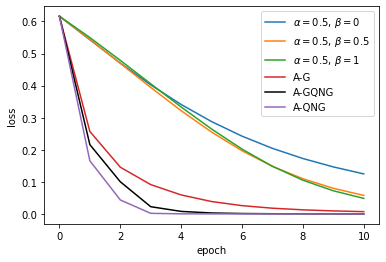

Regularization parameter for QNG (beta=1): 0.1


In [28]:
#plot result


plt.ylabel('loss')
plt.xlabel('epoch')
legend=[]
for i in range(len(learning_rates)):
    legend.append("$\\alpha="+str(learning_rates[i])+"$, "+"$\\beta="+str(beta_gradient[i])+"$")
    plt.plot(loss_standard_descent[i])

legend.append("A-G")
plt.plot(AG_loss_history)

legend.append("A-GQNG")
plt.plot(AGQNG_loss_history,"black")

legend.append("A-QNG")
plt.plot(AQNG_loss_history)



plt.legend(legend)
plt.show()

print("Regularization parameter for QNG (beta=1):",qfi_regularization)

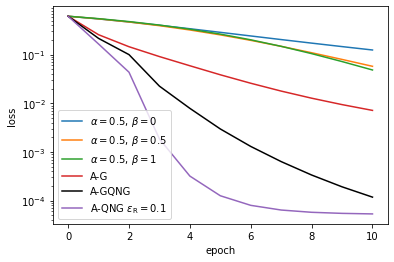

In [29]:
plt.ylabel('loss')
plt.xlabel('epoch')
legend=[]
for i in range(len(learning_rates)):
    legend.append("$\\alpha="+str(learning_rates[i])+"$, "+"$\\beta="+str(beta_gradient[i])+"$")
    plt.plot(loss_standard_descent[i])

legend.append("A-G")
plt.plot(AG_loss_history)

legend.append("A-GQNG")
plt.plot(AGQNG_loss_history,"black")

legend.append("A-QNG $\\epsilon_\\mathrm{R}=$"+str(qfi_regularization))
plt.plot(AQNG_loss_history)


plt.legend(legend)
ax=plt.gca()
ax.set_yscale('log')

plt.show()

Compare effect of regularization on quantum natural gradient (QNG) (beta=1). Different regularization parameters are used. Note that too small value makes it unable to converge, while too large values lead to decreased performance.

Generalized quantum natural gradient (GQNG) (beta=0.5) does not need regularization as it is instrinscially stable.

In [31]:
_,_,AQNG0_loss_history,_,_=do_optimization(optimization_strategy=1,beta=1,qfi_regularization=10**0)

_,_,AQNG1_loss_history,_,_=do_optimization(optimization_strategy=1,beta=1,qfi_regularization=10**-1)
_,_,AQNG2_loss_history,_,_=do_optimization(optimization_strategy=1,beta=1,qfi_regularization=10**-2)
_,_,AQNG3_loss_history,_,_=do_optimization(optimization_strategy=1,beta=1,qfi_regularization=10**-3)

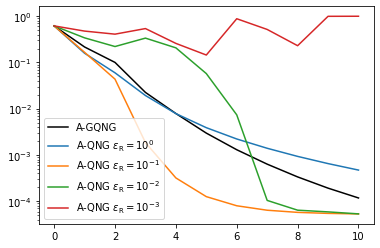

In [32]:
legend=[]
legend.append("A-GQNG")
plt.plot(AGQNG_loss_history,"black")

legend.append("A-QNG $\\epsilon_\\mathrm{R}=10^{0}$")
plt.plot(AQNG0_loss_history)

legend.append("A-QNG $\\epsilon_\\mathrm{R}=10^{-1}$")
plt.plot(AQNG1_loss_history)

legend.append("A-QNG $\\epsilon_\\mathrm{R}=10^{-2}$")
plt.plot(AQNG2_loss_history)

legend.append("A-QNG $\\epsilon_\\mathrm{R}=10^{-3}$")
plt.plot(AQNG3_loss_history)

plt.legend(legend)
ax=plt.gca()
ax.set_yscale('log')

plt.show()